In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from typing import Literal

from fairdivision.algorithms.xp_ece import get_efx_preserving_agent, create_envy_graph, reallocate_bundles
from fairdivision.utils.agents import Agents
from fairdivision.utils.allocation import Allocation
from fairdivision.utils.generators import generate_agents, generate_items, generate_valuations, AdditiveGenerator, ValuationsGenerator
from fairdivision.utils.helpers import print_valuations
from fairdivision.utils.items import Items

In [2]:
def xp_ece(agents: Agents, items: Items, max_attempts: int = 1000) -> Allocation:
    """
    Returns an allocation for the given `agents` and `items`.

    While there are still unallocated items, it gives the favorite one to an agent that will certainly preserve the EFX
    property of the allocation. If more agents are preserving EFX, one is chosen randomly. Additionally, the algorithm
    uses an envy graph to redistribute bundles if no EFX-preserving agent is present. In case there are simultaneously
    no envy cycles and no agents preserving EFX property, the algorithm starts from scratch. Random choice of the agent
    receiving an item ensures a high probability of a different outcome in each rerun.
    """

    for stuck_count in range(max_attempts):
        items_left = items.copy()
        allocation = Allocation(agents)

        while items_left.size() > 0:
            efx_preserving_agent = get_efx_preserving_agent(agents, items_left, allocation)

            while efx_preserving_agent is None:
                envy_graph = create_envy_graph(agents, allocation)

                try:
                    cycle = nx.find_cycle(envy_graph)

                    reallocate_bundles(cycle, allocation)
                    efx_preserving_agent = get_efx_preserving_agent(agents, items_left, allocation)
                except nx.NetworkXNoCycle:
                    break

            if efx_preserving_agent is None:
                break
            else:
                favorite_item = efx_preserving_agent.get_favorite_item(items_left)
                allocation.allocate(efx_preserving_agent, favorite_item)
                items_left.remove_item(favorite_item)
        else:
            return allocation, stuck_count

    # To retrieve a particularly hard example if it appears.
    print_valuations(agents, items)
    print()

    raise Exception("No EFX allocation found")

In [16]:
def run_and_write_stuck_counts(n: int, m: int, file_path: str, generator: ValuationsGenerator, iterations: int) -> None:
    with open(file_path, "w+") as file:
        stuck_counts = []
    
        for i in range(iterations):
            if i % 50000 == 0:
                print(i, end=" ")
    
            agents = generate_agents(n)
            items = generate_items(m)
            
            generate_valuations(agents, items, generator)
    
            allocation, stuck_count = xp_ece(agents, items)
    
            if stuck_count >= 1:
                stuck_counts.append(stuck_count)

        file.write(",".join(map(lambda stuck_count: str(stuck_count), stuck_counts)))


def read_and_draw(file_path: str, title: str) -> None:
    with open(file_path, "r") as file:
        stuck_counts_strings = filter(lambda token: len(token) > 0, file.readline().split(","))
        stuck_counts = list(map(lambda stuck_count: int(stuck_count), stuck_counts_strings))
    
        bins = np.arange(0.5, max(stuck_counts) + 1.5, 1)
    
        plt.figure(figsize=(15, 6))
        
        tick_step = (max(stuck_counts) // 10) + 1
        max_tick = max(stuck_counts) // tick_step * (tick_step+1) + 1
        plt.xticks(np.arange(1, max_tick, tick_step))
        
        plt.hist(stuck_counts, bins=bins, color="#f6c85f")
    
        plt.title(title, fontsize=24)
    
        plt.xlabel("stuck count", fontsize=20)
        plt.ylabel("number of instances", fontsize=20)

        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
    
        instances_per_stuck_count = dict()
    
        for stuck_count in stuck_counts:
            if stuck_count in instances_per_stuck_count:
                instances_per_stuck_count[stuck_count] += 1
            else:
                instances_per_stuck_count[stuck_count] = 1
    
        min_height = max(instances_per_stuck_count.values()) // 25
        
        for stuck_count in range(1, max(instances_per_stuck_count.keys()) + 1):
            if stuck_count in instances_per_stuck_count:
                plt.text(stuck_count, max(instances_per_stuck_count[stuck_count] // 2, min_height), instances_per_stuck_count[stuck_count], ha='center', fontsize=16)
        
        plt.show()

## Running the algorithm

### 5 agents and 9 items

In [9]:
n = 5
m = 9
generator = AdditiveGenerator(min=0, max=10)
iterations = 1000000

run_and_write_stuck_counts(n, m, "data/stuck_count_5_9.csv", generator, iterations)

0 50000 100000 150000 200000 250000 300000 350000 400000 450000 500000 550000 600000 650000 700000 750000 800000 850000 900000 950000 

### 5 agents and 14 items

In [10]:
n = 5
m = 14
generator = AdditiveGenerator(min=0, max=10)
iterations = 1000000

run_and_write_stuck_counts(n, m, "data/stuck_count_5_14.csv", generator, iterations)

0 50000 100000 150000 200000 250000 300000 350000 400000 450000 500000 550000 600000 650000 700000 750000 800000 850000 900000 950000 

## Drawing charts

### 5 agents and 9 items

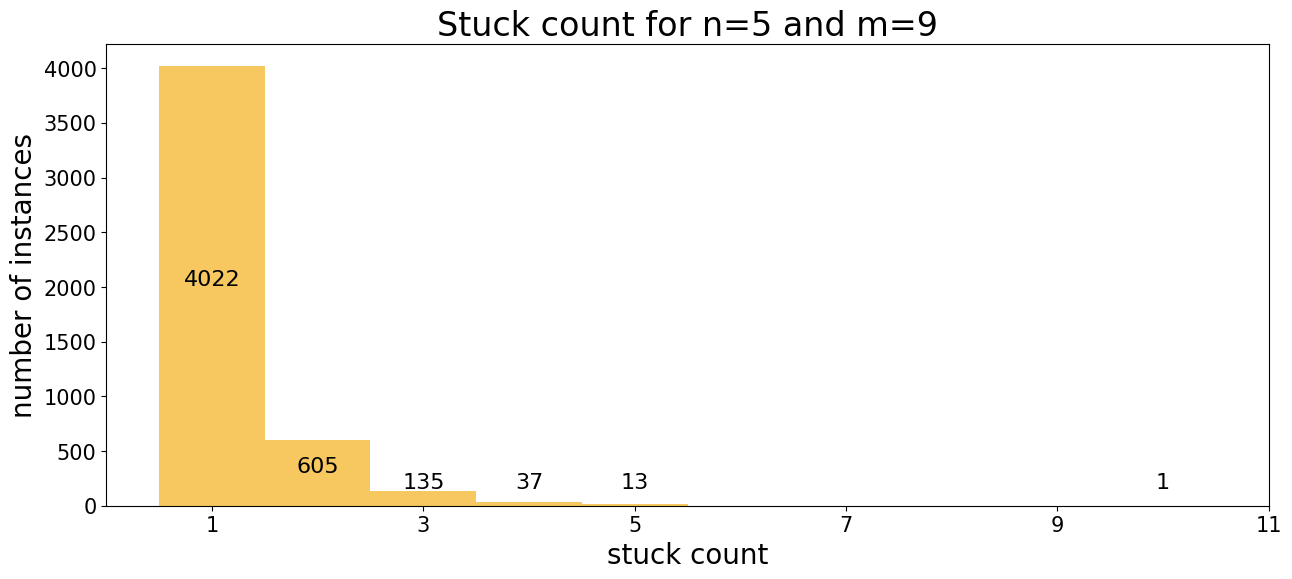

In [19]:
read_and_draw("data/stuck_count_5_9.csv", "Stuck count› for n=5 and m=9")

### 5 agents and 14 items

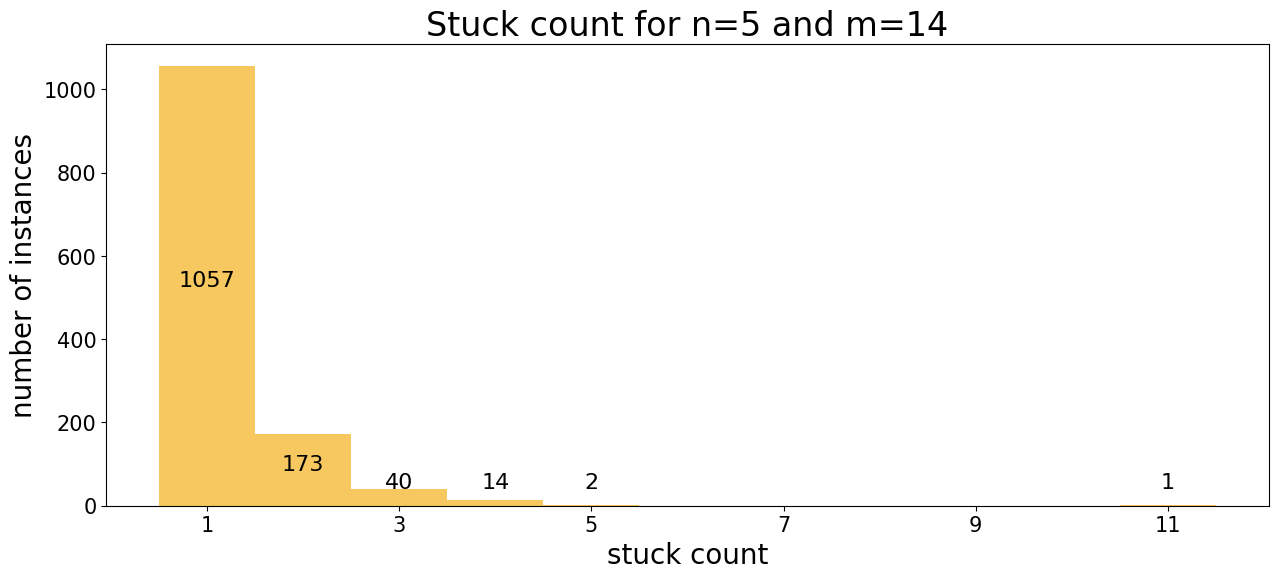

In [20]:
read_and_draw("data/stuck_count_5_14.csv", "Stuck count for n=5 and m=14")